In [1]:
import torch
from torch import nn
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

from PIL import Image

In [2]:
transforms = transforms.ToTensor()
dataset = MNIST(root='./data', train=True, download=True, transform=transforms)

dataloader = DataLoader(dataset, batch_size= 8, shuffle=True)
dataloader

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.20MB/s]


torch.Size([1, 28, 28])
torch.Size([28, 28])


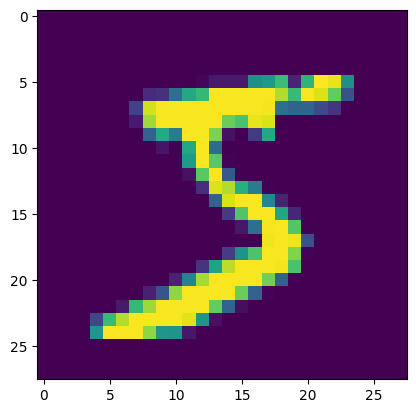

In [3]:
img, label = next(iter(dataset))
print(img.shape)
from matplotlib import pyplot as plt
img = img.squeeze()
print(img.shape)
plt.imshow(img.numpy(), interpolation='nearest')
plt.show()

In [4]:
class VAE(nn.Module):
  def __init__(self, input_shape, latent):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(input_shape, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),

        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),

        nn.Flatten()
    )

    self.latent_dim = latent
    self.fc_mu = nn.Linear(256 * 1 * 1, self.latent_dim)
    self.fc_logvar = nn.Linear(256 * 1 * 1, self.latent_dim)
    self.decoder_input = nn.Linear(self.latent_dim, 256 * 1 * 1)

    self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 1, 1)),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, input_shape, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )


  def encode(self, x):
    h = self.encoder(x)
    return self.fc_mu(h), self.fc_logvar(h)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

  def loss(self, recon, x, mu, logvar, beta=2.0):
        batch_size = x.size(0)


        recon_loss = nn.functional.mse_loss(recon, x, reduction='sum') / batch_size

        kl_loss = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())) / batch_size


        total_loss = recon_loss + beta * kl_loss

        return total_loss, recon_loss, kl_loss


  def decode(self, x):
    h = self.decoder_input(x)
    return self.decoder(h)

In [5]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(device)

cuda


In [6]:
model = VAE(1, 32).to(device)
input_dummy = torch.randn(1, 1, 28, 28).to(device)
_, _2 = model.encode(input_dummy)

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [10]:
#train

model.train()

epochs = 10

for epoch in range(epochs):
  train_loss = 0
  for img, label in dataloader:
    img = img.to(device)
    recon, mu, logvar = model(img.squeeze(0))
    loss, recon_loss, kl = model.loss(recon, img.squeeze(0), mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  avg_epoch_loss = train_loss / len(dataloader)
  print(f"Epoch: {epoch}, Loss: {avg_epoch_loss:.4f}")

Epoch: 0, Loss: 38.8036
Epoch: 1, Loss: 38.4754
Epoch: 2, Loss: 38.1778
Epoch: 3, Loss: 38.0234
Epoch: 4, Loss: 37.8931
Epoch: 5, Loss: 37.8070
Epoch: 6, Loss: 37.6897
Epoch: 7, Loss: 37.6049
Epoch: 8, Loss: 37.5661
Epoch: 9, Loss: 37.4963


torch.Size([28, 28])


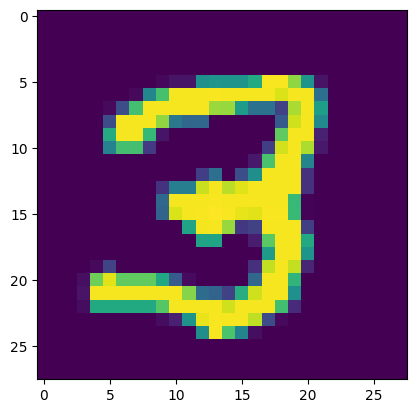

torch.Size([28, 28])


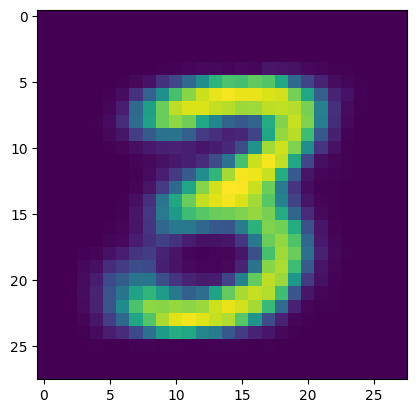

In [26]:
img, label = next(iter(dataloader))
img = img.to(device)

with torch.no_grad():
  reconstructed, mu, logvar = model(img.squeeze(0))

  img = img[0]
  img = img.squeeze()
  print(img.shape)
  plt.imshow(img.cpu().numpy(), interpolation='nearest')
  plt.show()

  reconstructed = reconstructed[0]
  reconstructed = reconstructed.squeeze()
  print(reconstructed.shape)
  plt.imshow(reconstructed.cpu().numpy(), interpolation='nearest')
  plt.show()